In [119]:
import numpy as np
from scipy import linalg as la
from scipy import sparse
import matplotlib.pyplot as plt
import sympy as sy
import math

# CONDITIONING AND STABILITY

**EXERCISE 1**

In [1]:
def my_cond_num(A):
    sv = la.svdvals(A)
    svmax = np.max(sv)
    svmin = np.min(sv)
    
    if np.abs(svmin) < 1e-5:
        condNum = np.inf
    else:
        condNum = svmax / svmin
    
    return condNum

In [9]:
B = np.array([[1,2],[3,4]])
C, X = la.qr(B)

np.linalg.cond(C)

1.0

In [11]:
my_cond_num(C)

1.0

**EXERCISE 2**

In [23]:
def exper():
    w_roots = np.arange(1, 21)

    plt.scatter(w_roots.real,w_roots.imag,c='b', marker='o',s=20, label = "Original")
    
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())

    maxacn = 0
    maxrcn = 0
    for i in range(100):
        r = np.random.normal(1, 1e-10, 21)
        new_coeffs = w_coeffs*r
        new_roots = np.roots(np.poly1d(new_coeffs))

        if i == 99:
            plt.scatter(new_roots.real,new_roots.imag, c='k',marker='.', s = 0.1, label = 'Perturbed')
        else:
            plt.scatter(new_roots.real,new_roots.imag, c='k',marker='.', s = 0.1)

        abscn = la.norm(new_roots - w_roots, np.inf) / la.norm(new_coeffs - w_coeffs, np.inf)
        
        if abscn > maxacn:
            maxacn = abscn

        relcn = abscn * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)

        if relcn > maxrcn:
            maxrcn = relcn

    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.legend(loc = 'best')
    plt.show()
    
    print("Absolute Condition Number: " + str(maxacn))
    print("Relative Condition Number: " + str(maxrcn))  

    return maxacn, maxrcn

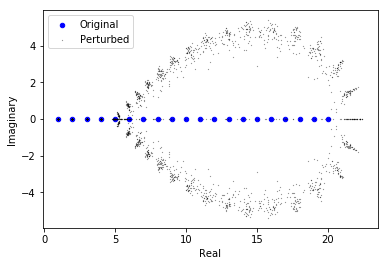

Absolute Condition Number: 5.69032475440970e-8
Relative Condition Number: 39273937915.0330


In [24]:
absCond, relCond = exper()

**EXERCISE 3**

In [29]:
def eigen_cond(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    lambda_old = la.eigvals(A)
    A_tilde = A + H
    lambda_new = la.eigvals(A_tilde)
    
    absCond = la.norm(lambda_old - lambda_new, 2)/la.norm(H, 2)

    relCond = (la.norm(A, 2)/la.norm(lambda_old, 2))*absCond
    
    return absCond, relCond

In [30]:
A = np.random.random((10, 10))
absCond, relCond = eigen_cond(A)

print("Absolute Condition Number: " + str(absCond))
print("Relative Condition Number: " + str(relCond))

Absolute Condition Number: 1280666759.5592458
Relative Condition Number: 1207958370.7701972


**EXERCISE 4**

In [31]:
def cond_plot(x_min, x_max, y_min, y_max, res):
    
    xvals = np.linspace(x_min, x_max, res)
    yvals = np.linspace(y_min, y_max, res)
    vals = np.zeros((res, res))
    
    for i in range(res):
        for j in range(res):
            A = np.array([[1,xvals[i]],[yvals[j],1]])
            vals[i,j] = eigen_cond(A)[1]
    
    plt.pcolormesh(xvals, yvals, vals, cmap='gray_r')
    plt.colorbar()
    plt.show()

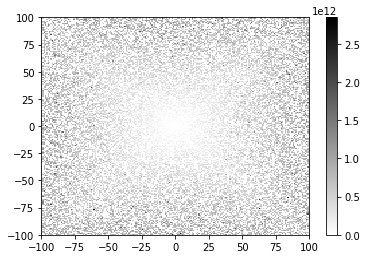

In [32]:
cond_plot(-100, 100, -100, 100,200)

**EXERCISE 5**

In [37]:
def poly_cond(n):
    xk, yk = np.load('stability_data.npy').T
    
    A = np.vander(xk, n+1) 
    ck_inv = la.inv(A.T @ A) @ A.T @ yk
    
    Q, R = la.qr(A, mode='economic')
    ck_QR = la.solve_triangular(R, Q.T @ yk)
    
    plt.scatter(xk, yk, label='Original Data', s=2)
    plt.plot(xk, np.polyval(ck_inv, xk), label="Normal Equations")
    plt.plot(xk, np.polyval(ck_QR, xk), label = "QR Solver")
    plt.title("Fit of Data for Polynomial of Degree " + str(n))
    plt.legend()
    plt.show()
    
    forwardError1 = la.norm(A @ ck_inv - yk, 2)
    forwardError2 = la.norm(A @ ck_QR - yk, 2)
    
    #print("Forward Error of Normal Equations: %d" %forwardError1)
    #print("Forward Error of QR Decomposition Solution: %d" %forwardError2)
    
    return forwardError1, forwardError2

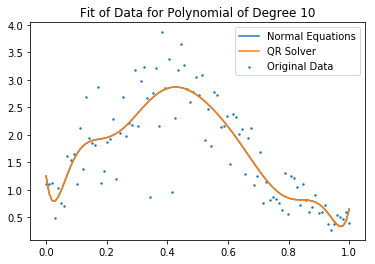

(4.644340976351729, 4.644309587561731)

In [39]:
poly_cond(10)

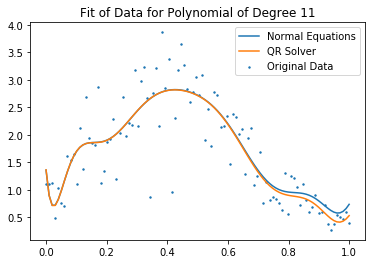

(4.661742595788919, 4.622026000927542)

In [40]:
poly_cond(11)

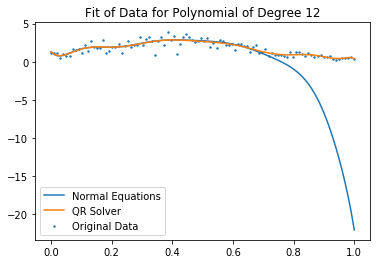

(50.52950955679529, 4.593408027059241)

In [41]:
poly_cond(12)

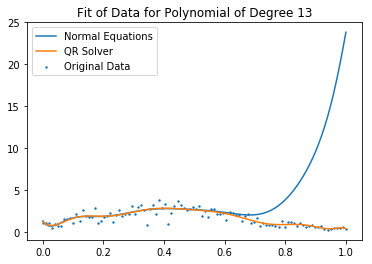

(55.86733314419027, 4.593389524104735)

In [43]:
poly_cond(13)

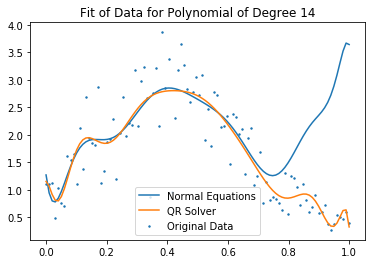

(10.200539615028042, 4.568370935743621)

In [44]:
poly_cond(14)

**EXERCISE 6**

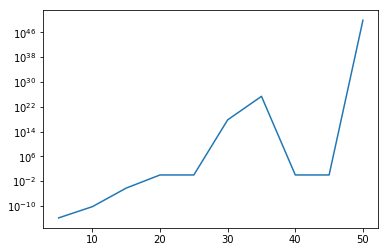

In [58]:
x = sy.Symbol('x')
ferror = []

for n in np.arange(5,55,5):
    n = int(n)
    I_integral = float(sy.integrate((x**n)*(sy.exp((x-1))), (x, 0, 1)))
    I_sum = float((-1)**n)*sy.subfactorial(n)+ ((-1)**(n+1))*(sy.factorial(n)/math.e)
    
    ferror.append(abs(I_sum-I_integral)/abs(I_integral))    
    
plt.plot(np.arange(5,55,5),error)
plt.yscale('log')
plt.show()

# ITERATIVE SOLVERS

**EXERCISE 1 and 2**

In [92]:
def jacobiIter(A, b, tol=1e-5, maxiters=5000, plot=False):
    
    D = np.diagonal(A)
    Dinv = np.diag(1 / np.diag(A))

    x = np.zeros(len(b))
    
    errors = []
    err = tol + 1
    itr = 1
    
    while itr < maxiters and err > tol:     
        xp = x + Dinv @ b - Dinv @ (A @ x)
        abserr = np.linalg.norm(A@xp - b, np.inf)
        errors.append(abserr)
        err = np.linalg.norm(xp - x, np.inf)
        itr += 1
        x = xp
    
    if plot:
        fig = plt.figure(figsize=(8,6))
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi Method')
        plt.semilogy(np.arange(1, itr, 1), errors)
    
    return x

In [93]:
def diag_dom(n, num_entries=None):
    """
    Generate a strictly diagonally dominant (n, n) matrix.
    
    Parameters:
        n (int): The dimension of the system.
        num_entries (int): The number of nonzero values.
            Defaults to n^(3/2)-n.
            
    Returns:
        A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
        
    """

    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

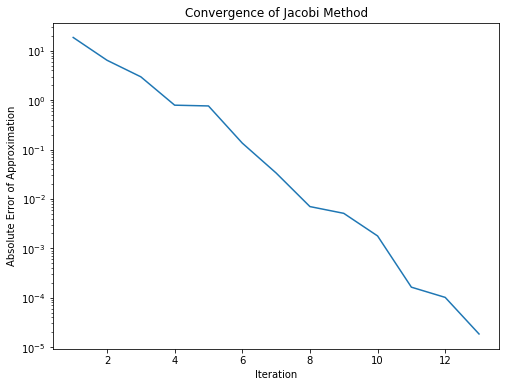

In [94]:
A = diag_dom(10)
b = np.random.random((10,1))
x_j = jacobiIter(A, b, plot=True)
x_s = la.solve(A, b)

In [95]:
np.allclose(A @ x_j, b)

True

In [96]:
np.allclose(A @ x_s, b)

True

**EXERCISE 3**

In [114]:
def GS(A, b, tol=1e-5, maxiters=5000, plot = False):
    
    x = np.zeros(b.shape)
    xp = np.zeros(b.shape)
    D = np.diagonal(A)
    itr = 0
    err = tol + 1
    errors = [np.linalg.norm(b)]
    
    while itr < maxiters and err > tol:
        xcopy = np.copy(x)
        for i in range(len(x)):
            xcopy[i] = xcopy[i] + (b[i] - A[i,:] @ xcopy)/D[i]
        xp = xcopy
        
        err = np.linalg.norm(xp - x)
        errors.append(np.linalg.norm(A @ xp - b))
        x = xp
        itr += 1
    
    if plot:
        plt.semilogy(range(itr+1),errors)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error')
        plt.title('Convergence of Gauss-Seidel')
        plt.show()
    
    return x

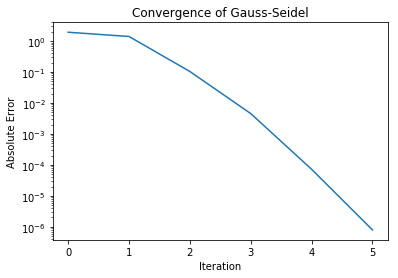

In [116]:
x_j = GS(A, b, plot = True)
x_s = la.solve(A, b)

In [117]:
np.allclose(A @ x_j, b)

True

In [118]:
np.allclose(A @ x_s, b)

True

**EXERCISE 4**

In [145]:
def GSsparse(A, b, tol=1e-5, maxiters=5000, plot=False):
    x = np.zeros(b.shape)
    xp = np.zeros(b.shape)
    
    errors = []
    itr = 0
    err = tol + 1
    
    while itr < maxiters and err > tol:
        xcopy = np.copy(x)
        for i in range(len(x)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend].flatten() @ xcopy[A.indices[rowstart:rowend]]
            
            xcopy[i] = xcopy[i] + (1/A[i,i]) * (b[i] - Aix)
        
        xp = xcopy
        
        err = np.linalg.norm(xp - x)
        errors.append(err)
        x = xp
        itr += 1

    if plot:
        plt.semilogy(range(itr),errors)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error')
        plt.title('Convergence of Gauss-Seidel')
        plt.show()
    
    return x, itr

In [139]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

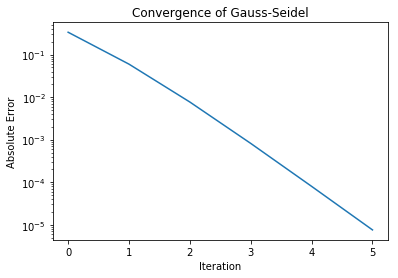

In [146]:
x_j = GSsparse(A, b, plot=True)

**EXERCISE 5**

In [147]:
def GSsparse2(A, b, w, tol=1e-5, maxiters=5000, plot=False):
    x = np.zeros(b.shape)
    xp = np.zeros(b.shape)
    
    errors = []
    itr = 0
    err = tol + 1
    
    while itr < maxiters and err > tol:
        xcopy = np.copy(x)
        for i in range(len(x)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend].flatten() @ xcopy[A.indices[rowstart:rowend]]
            
            xcopy[i] = xcopy[i] + (w/A[i,i]) * (b[i] - Aix)
        
        xp = xcopy
        
        err = np.linalg.norm(xp - x)
        errors.append(err)
        x = xp
        itr += 1

    if plot:
        plt.semilogy(range(itr),errors)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error')
        plt.title('Convergence of Gauss-Seidel')
        plt.show()
    
    return x, itr

In [149]:
omegas = np.linspace(.1, 1, 10)
its = np.zeros(len(omegas))
for index, w in enumerate(omegas):
    x_j, ii = GSsparse2(A, b, w, plot=False)
    its[index] = ii

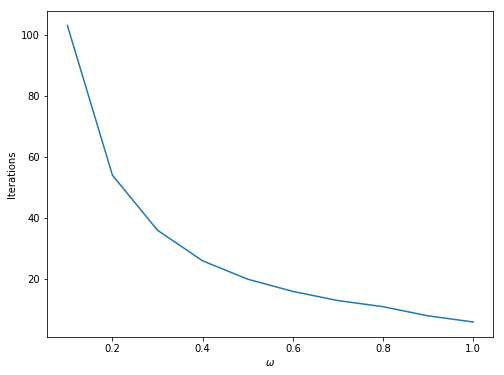

In [150]:
fig = plt.figure(figsize=(8,6))
plt.plot(omegas, its)
plt.xlabel(r'$\omega$')
plt.ylabel('Iterations')
plt.show()